In [ ]:

from occupancy.datasets.nuscenes import NuScenesDataset, NuScenesOccupancyDataset
from nuscenes.nuscenes import NuScenes
nusc = NuScenesOccupancyDataset(
    data_dir='/mnt/f/datasets/nuscenes/nuScenes-Occupancy-v0.1/', binary=False)


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import Tensor

In [ ]:
def occ_shuffle(occ: Tensor, cube_size: int = 32, shuffle_rato: float = 0.2):
    total_cubes = (occ.shape[-3] // cube_size) * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size)
    total_shuffle = int(total_cubes * shuffle_rato)
    cubes = torch.zeros(occ.shape[0], occ.shape[1], total_cubes, cube_size, cube_size, cube_size)
    for i in range(occ.shape[-3] // cube_size):
        for j in range(occ.shape[-2] // cube_size):
            for k in range(occ.shape[-1] // cube_size):
                ind = i * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size) + j * (occ.shape[-1] // cube_size) + k
                cubes[:, :, ind] = occ[:, :, i * cube_size:(i + 1) * cube_size, j * cube_size:(j + 1) * cube_size, k * cube_size:(k + 1) * cube_size] 
    ind_to_shuffle = torch.randperm(total_cubes)[:total_shuffle]
    shuffle_ind = torch.randperm(total_shuffle)
    cubes[:, :, ind_to_shuffle] = cubes[:, :, ind_to_shuffle][:, :, shuffle_ind]
    shuffled = torch.zeros_like(occ)
    for i in range(occ.shape[-3] // cube_size):
        for j in range(occ.shape[-2] // cube_size):
            for k in range(occ.shape[-1] // cube_size):
                ind = i * (occ.shape[-2] // cube_size) * (occ.shape[-1] // cube_size) + j * (occ.shape[-1] // cube_size) + k
                shuffled[:, :, i*cube_size:(i+1)*cube_size, j*cube_size:(j+1)*cube_size, k*cube_size:(k+1)*cube_size] = cubes[:, :, ind]
    return shuffled
                
    

In [ ]:
occ = nusc[12]
occ = F.interpolate(occ.unsqueeze(0).float(), scale_factor=2, mode='trilinear', align_corners=True).squeeze(0).argmax(0)
occ = F.one_hot(occ, num_classes=18).permute(3, 0, 1, 2).argmax(0)
occ = occ_shuffle(occ[None, None, ...], 64,0.2)[0, 0]
i,j,k = torch.where(occ)
c = occ[i,j,k]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(i,j,k, c=c, marker='s', s=1)
ax.set_xlim(0, occ.shape[-3])
ax.set_ylim(0, occ.shape[-2])
ax.set_zlim(0, occ.shape[-1])
ax.set_box_aspect((1,1,occ.shape[-1]/occ.shape[-2]))


In [ ]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained('stabilityai/sdxl-vae')

In [ ]:

from occupancy.datasets.nuscenes import NuScenesDataset, NuScenesOccupancyDataset
from nuscenes.nuscenes import NuScenes
nusc = NuScenesDataset(
    data_dir='/mnt/f/datasets/nuscenes/')

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.v2.functional as F


data = nusc[0]

In [ ]:
img = data.cam_front.data.cuda()

In [ ]:
vae.cuda()

In [16]:
img_h = vae.decode(vae.encode(img).latent_dist.sample())

In [17]:
img_h.sample

tensor([[[[0.9164, 0.9111, 0.9170,  ..., 0.2332, 0.2407, 0.2506],
          [0.9154, 0.9190, 0.9259,  ..., 0.2264, 0.2512, 0.2607],
          [0.9189, 0.9213, 0.9266,  ..., 0.2264, 0.2513, 0.2602],
          ...,
          [0.2815, 0.2796, 0.2785,  ..., 0.3164, 0.3126, 0.3101],
          [0.2718, 0.2787, 0.2754,  ..., 0.3096, 0.3058, 0.3005],
          [0.2671, 0.2762, 0.2781,  ..., 0.3009, 0.3045, 0.3048]],

         [[0.9130, 0.9073, 0.9129,  ..., 0.2579, 0.2619, 0.2876],
          [0.9033, 0.9118, 0.9116,  ..., 0.2548, 0.2788, 0.2941],
          [0.9049, 0.9142, 0.9136,  ..., 0.2490, 0.2708, 0.2782],
          ...,
          [0.3075, 0.3068, 0.3091,  ..., 0.3345, 0.3322, 0.3310],
          [0.3070, 0.3052, 0.3050,  ..., 0.3290, 0.3234, 0.3171],
          [0.2998, 0.3062, 0.3088,  ..., 0.3241, 0.3274, 0.3229]],

         [[0.9606, 0.9610, 0.9695,  ..., 0.2396, 0.2485, 0.2446],
          [0.9636, 0.9677, 0.9745,  ..., 0.2353, 0.2528, 0.2533],
          [0.9685, 0.9727, 0.9797,  ..., 0

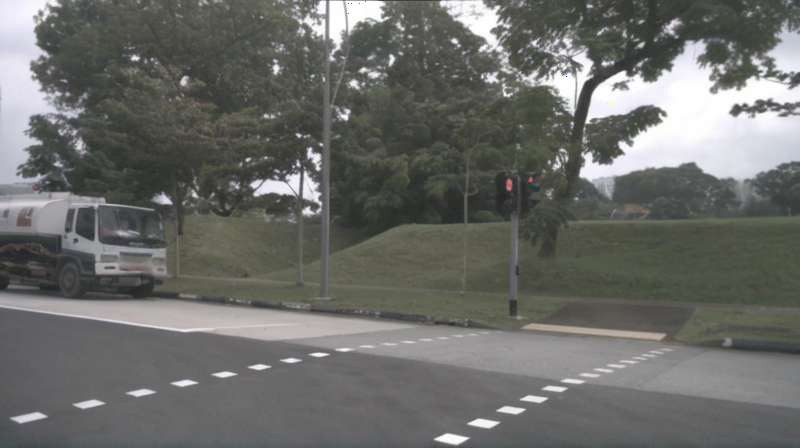

In [18]:
F.to_pil_image(img_h.sample[0])

In [ ]:
from torch import nn, Tensor 
import torch

from occupancy.models.unet_2d import UnetEncoder2d,UnetDecoder2d
from occupancy.pipelines.autoencoderkl_2d import GaussianDistribution

class VAEAdaptor(nn.Module):
    def __init__(self, vae: AutoencoderKL, base_channels: int, num_layers: int):
        super().__init__()
        self.laten_scale = 1 / 10
        self.vae = vae
        self.vae.requires_grad_(False)
        self.encoder_layers = UnetEncoder2d(4, 1024, base_channels, 2, num_layers)
        self.decoder_layers = UnetDecoder2d(1024, 4, base_channels, 2, num_layers)
        
    def encode(self, x: Tensor) -> Tensor:
        latent = self.encoder_layers(self.vae.encode(x).latent_dist.sample())
        latent_dist = GaussianDistribution.from_latent(latent, self.laten_scale)
        return latent_dist
    
    def decode(self, x: Tensor) -> Tensor:
        return self.vae.decode(self.decoder_layers(x))

In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)


ValueError: The checkpoint you are trying to load has model type `depth_anything` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.

In [3]:
import numpy as np
from PIL import Image
import cv2
import torch
import os
os.chdir('/home/zc2309/workspace/occupancy/Depth_Anything')
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
model = DepthAnything.from_pretrained("LiheYoung/depth_anything_vitl14")

transform = Compose([
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image = np.array(image) / 255.0
image = transform({'image': image})['image']
image = torch.from_numpy(image).unsqueeze(0).cuda()
model.cuda()

depth = model(image)


In [8]:
depth[0].max()

tensor(191.9806, device='cuda:0', grad_fn=<MaxBackward1>)

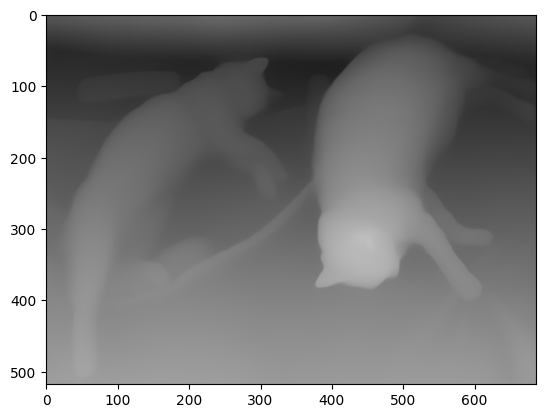

In [6]:
import torchvision.transforms.v2.functional as TF
import matplotlib.pyplot as plt
plt.imshow(TF.to_pil_image(depth[0].cpu(), mode='F'))

In [ ]:
import torch
torch.export.export()

In [ ]:
import torch
from occupancy.ops import view_as_cartesian, view_as_polar


x = torch.rand(1, 1, 64, 64, 64)
z = view_as_polar(x, (512, 512, 512), mode='bilinear')
x_ = view_as_cartesian(z, (64, 64, 64), mode='bilinear')

In [ ]:
(x - x_).abs().max()